In [1]:
# modules à importer

import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from skimage import io, transform
import torch.autograd as ag
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from PIL import Image
import os
from scipy import signal
from sklearn.metrics import mean_squared_error
from torch.autograd import Variable
import time
from functools import reduce

torch.set_printoptions(precision=6)

torch.Size([3, 128, 128])
0 torch.Size([22, 3, 128, 128])
1 torch.Size([22, 3, 128, 128])
2 torch.Size([22, 3, 128, 128])


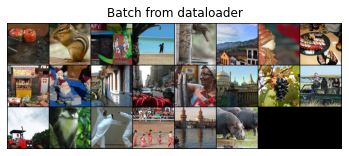

In [2]:
# Constructing the training set and the test set


#### function declaration  

class ImageDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images to read
            transform (callable, optional): Optional transform to be applied
                on the images.
        """
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        path, dirs, files = next(os.walk(self.root_dir))
        file_count = len(files)
        return file_count

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        path, dirs, files = next(os.walk(self.root_dir))
        img_name = os.path.join(self.root_dir, files[idx])
        image = io.imread(img_name)

        if self.transform:
            image = self.transform(image)

        return image



class RandomCrop(object):
    """Transform which randomly crop the image

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]


        return image
    

class ToTensor(object):
    """Convert ndarrays in images to Tensors."""

    def __call__(self, images):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        images = images.transpose((2, 0, 1))
        return torch.from_numpy(images)

    
def show_image_batch(images_batch):
    """Show image for a batch of samples."""
    batch_size = len(images_batch)
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    plt.title('Batch from dataloader')
    
    
####

    
# Load training dataset
transformed_dataset = ImageDataset(root_dir='./data/flickr/', 
                                           transform=transforms.Compose([
                                            RandomCrop(128), ToTensor()])
                                  )
print(transformed_dataset[1].size())
dataloader = DataLoader(transformed_dataset, batch_size=22, shuffle=True, num_workers=0)

for i_batch, batch_images in enumerate(dataloader):
    print(i_batch, batch_images.size())

    # observe 2th batch and stop.
    if i_batch == 2:
        plt.figure()
        show_image_batch(batch_images)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break


In [3]:
#Declaring the network functions 


def periodic_shuffling(T, C):
    """Shuffling function used in the subpix layer described in Fig2 from Theis paper. 
    To sum up, this function is used to augment the resolution of an image (dimension H and W) by recombining pixels from different channels C.
    In Theis paper, inputs of dimension (C, W, H) are used to get ouptputs of dimension (C/4, 2*H, 2*W)
    For more details about the function behavior, please refer to Shi et al, 2016 (equation 3 and 4). 
    
    Args:
        T: input tensor
        C: (int) number of channels of the output tensor (C = input_tensor_channels/4)
    """
    
    T_copy = T.clone()
    batch_size = T.size()[0]
    H = T.size()[2]
    W = T.size()[3]
    T = T.view(batch_size, C, H*2, W*2)
                
    T[:, :, ::2, ::2] = T_copy[:, 0:C, :, :]
    T[:, :, 1::2, ::2] = T_copy[:, C:2*C, :, :]
    T[:, :, ::2, 1::2] = T_copy[:, 2*C:3*C, :, :]
    T[:, :, 1::2, 1::2] = T_copy[:, 3*C:4*C, :, :]

    return T
    
    
def mirror_padding(x, padding_size):
    """Mirror pad the input data  
    Args:
        x: input data
        padding_size: (int) number of pixels added to each side of the input data
    """
    up_line = x[:, :, 0:padding_size, :].flip(2)
    left_col = x[:, :, :, 0:padding_size].flip(3)
    right_col = x[:, :, :, -padding_size:].flip(3)
    bottom_line = x[:, :, -padding_size:, :].flip(2)
    left_up_corner = left_col[:, :, 0:padding_size, :].flip(2)
    right_up_corner = right_col[:, :, 0:padding_size, :].flip(2)
    left_bottom_corner = left_col[:, :, -padding_size:, :].flip(2)
    right_bottom_corner = right_col[:, :, -padding_size:, :].flip(2)

    x_mirror_pad = torch.cat((torch.cat((left_up_corner, up_line, right_up_corner), 3), torch.cat((left_col, x, right_col), 3), torch.cat((left_bottom_corner, bottom_line, right_bottom_corner), 3)), 2)
    return x_mirror_pad
    

def normalize_input(x):
    """normalize the input data (centering followed by normalization)
    Args:
        x: input data
    """
    mean_channels = torch.mean(1.0*x, [2,3])
    mean_channels_images = (mean_channels.repeat_interleave(x.size()[2]*x.size()[3])).view(x.size()[0], x.size()[1], x.size()[2], x.size()[3])
    x_centered = x - mean_channels_images
    max_value = torch.max(x)
    min_value = torch.min(x)
    radius = max(max_value, abs(min_value))
    x_centered_normalized = x_centered/radius
    return x_centered_normalized, radius, mean_channels
    
def denormalize_output(x, radius, mean_channels):
    """denormalize the data (de-normalization followed by de-centering)
    Args:
        x: input data
        radius : (float) value of the normalization
        mean_channels : vector containing the mean of each channel of the former input
    """
    x_denormalized = x*radius
    mean_channels_images = (mean_channels.repeat_interleave(x.size()[2]*x.size()[3])).view(x.size()[0], x.size()[1], x.size()[2], x.size()[3])
    x_denormalized_centered = x_denormalized + mean_channels_images
    return x_denormalized_centered



def compute_gsm(x, var, phi, nScale):
    """Compute the gaussian scale mixture used to train the network (see Fig 2 and eq 12 of Theis et al).
    We supposed the gaussian to be centered. So, the mixture depends on 3 parameters : 
    - the number of considered gaussian
    - the variance of each gaussian
    - the weight of each gaussian
    Args:
        x: input data
        nScale : (int) number of scales used for constructing the mixture (6 by default)
        var : 1-by-nScale vector containing the variances of each gaussian
        phi : 1-by-nScale vector containing the weigths associated to each gaussian
    """
    gsm = 0.0
    
    phi = torch.abs(phi)
    var = torch.abs(var)
    phi_s_sum = torch.sum(phi, 0).unsqueeze(0)
    phi_norm = phi/phi_s_sum
    
    for s in range(nScale):
        var_s = var[s, :].view(1, -1, 1, 1)
        phi_s = phi_norm[s, :].view(1, -1, 1, 1)
        gaussian = phi_s*(1.0/(torch.sqrt(2*np.pi*var_s)))*torch.exp(-0.5*(x**2/var_s))
        gsm += gaussian
    return gsm


def mean_bit_per_px(x_quantized, phi, var):
    """compute the mean number of bit used to encode 1 symbol of the latent vector
    This function computes the expression -log(Q(z)) given in eq 8 of Theis paper. 
    Args:
        x_quantized: quantized data obtained at the output of the encoder
        var : vector containing the variances of each gaussian
        phi : vector containing the weigths associated to each gaussian
    """
    u = torch.arange(-0.5, 0.5+0.05, 0.05).cuda()   
    gsm_stacked = []
    #u_stacked = []
    for i in range(len(u)):
        x = x_quantized + u[i]
        gsm = compute_gsm(x, var, phi, 6)
        gsm_stacked.append(gsm)
        #u_stacked.append(torch.ones(gsm.size()).cuda()*u[i])
    
    gsms = torch.stack(gsm_stacked, dim=0)
    #us = torch.stack(u_stacked, dim=0)
    integral_u = torch.trapz(gsms, dx=0.05, dim=0)
    nb_bits = (-torch.log2(torch.clamp(integral_u, min=np.exp(-10**2), max=1))).sum()
    if nb_bits < 0:
        #print("integral u : ", integral_u)
        print("nb_bits : ", nb_bits)
    return nb_bits/reduce(lambda x, y: x*y, list(x_quantized.size()))


"""
def sum_gsm(x, var, phi, nScale):
    gsm = 0.0
    
    phi = torch.abs(phi)
    var = torch.abs(var)
    phi_s_sum = torch.sum(phi, 0).unsqueeze(0)
    phi_norm = phi/phi_s_sum
    
    for s in range(nScale):
        var_s = var[s, :].view(1, -1, 1, 1)
        phi_s = phi_norm[s, :].view(1, -1, 1, 1)
        gaussian = phi_s*(1.0/(torch.sqrt(2*np.pi*var_s)))*torch.exp(-0.5*(x**2/var_s))
        gsm += gaussian
    #gsm_sum = (torch.log2(gsm)).sum()
    gsm_sum = gsm.sum()
    return gsm_sum

    
def entropy_rate(x_quantized, phi, var):
    u = torch.arange(-0.5, 0.5+0.01, 0.01).cuda()        
    gsm_sum = torch.zeros(len(u)).cuda()
    for i in range(len(u)):
        x = x_quantized + u[i]
        gsm_sum_i = sum_gsm(x, var, phi, 6)
        gsm_sum[i] = gsm_sum_i

    integral_u = torch.trapz(gsm_sum, u)
    #print("gsm sum : ", gsm_sum)
    #print("integral over u : ", integral_u)
    entropy = -torch.log2(integral_u)
    
    return entropy
    
"""
    
def compute_mask(nb_ones, dims):
    """ to use only if you want to do the part of incremental training mentionned in 3.2 of Theis et al. 
    This function enables to compute the mask updates. 
    Args:
        nb_ones : (int) number of coefficient already computed
        dims : (vector of int) (C, H, W) : dimension of the input whose the mask is applied on.  
    """
    mask = torch.zeros(dims)
    indices = np.arange(nb_ones)
    mask_flatten = mask.view(-1, 1, 1, 1)
    mask_flatten[indices] = 1
    mask_reshaped = mask_flatten.view(dims)
    return mask_reshaped



class MyQuantization(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        
        The forward method of this class returns the rounding of the given input
        """
        ctx.save_for_backward(input)
        return torch.round(input)
    
    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        
        The backward method of this class uses a approximation for calculating the derivative of the rounding function. 
        We took the approximation given in Theis et al in eq 6, and replaced the derivative by 1
        """
        input, = ctx.saved_tensors
        return grad_output

        
        
class MyClipping(torch.autograd.Function):
    """ This function controls the range of values in the output of the decoder (to be sure they lie in [0, 255]) """
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return torch.round(input).clamp(min=0, max=255)
    
    @staticmethod
    def backward(ctx, grad_output):
        input = ctx.saved_tensors
        return grad_output

 

In [4]:
#Define the Convolutional Autoencoder 
    #size of input image : 3x128x128
    
class LossyCompAutoencoder(nn.Module):
    def __init__(self):
        super(LossyCompAutoencoder, self).__init__()
       
        #Encoder
            # input block
        self.conv1 = nn.Conv2d(3, 64, 5, stride=2, padding=0)  
        self.conv2 = nn.Conv2d(64, 128, 5, stride=2, padding=0)
            # residual block 1
        self.resConv1_1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.resConv1_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
            # residual block 2
        self.resConv2_1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.resConv2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
            # residual block 3
        self.resConv3_1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.resConv3_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
            # output block
        self.conv3 = nn.Conv2d(128, 96, 5, stride=2, padding=0)
        self.quantization = MyQuantization.apply
        

        #Decoder
            # subpixel 1
        self.subpix1 = nn.Conv2d(96, 512, 3, stride=1, padding=1)
            # subpixel 2
        self.subpix2 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
            # subpixel 3
        self.subpix3 = nn.Conv2d(256//4, 12, 3, stride=1, padding=1)
            #residual block 1
        self.deconv1_1 = nn.Conv2d(512//4, 128, 3, stride=1, padding=1)
        self.deconv1_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
            #residual block 2
        self.deconv2_1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.deconv2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
            #residual block 3
        self.deconv3_1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.deconv3_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        
        self.clip = MyClipping.apply
        
        #Bit-rate      
        self.var = nn.Parameter(torch.Tensor(6, 96))
        self.phi = nn.Parameter(torch.Tensor(6, 96))
        self.var.data.uniform_(0, 1)
        self.phi.data.uniform_(0, 1)
        
        
    
    def forward(self, x, mask= 1, return_xq=False):
        #encoder
            # normalization
        x, radius, mean_channels = normalize_input(x)
            # mirror padding
        x = mirror_padding(x, 14)
 
            # input blocks
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x_c1 = x.clone()
            # residual block 1
        x = F.relu(self.resConv1_1(x))
        x = self.resConv1_2(x)
        x += x_c1
        x_c2 = x.clone()
            # residual block 2
        x = F.relu(self.resConv2_1(x))
        x = self.resConv2_2(x)
        x += x_c2
        x_c3 = x.clone()
            # residual block 3
        x = F.relu(self.resConv3_1(x))
        x = self.resConv3_2(x)
        x += x_c3
            # output block
        x = self.conv3(x)
            # quantization
        x = self.quantization(x)
            # add mask for incremental training
        x = x*mask
        x_quantized = x
        
       
        #decoder
            # subpixel 1
        x = self.subpix1(x)
        x = periodic_shuffling(x, 512//4)
        x_c4 = x.clone()
            # residual block 1
        x = F.relu(self.deconv1_1(x))
        x = self.deconv1_2(x)
        x += x_c4
        x_c5 = x.clone()
               # residual block 2
        x = F.relu(self.deconv2_1(x))
        x = self.deconv2_2(x)
        x += x_c5
        x_c6 = x.clone()
               # residual block 3
        x = F.relu(self.deconv3_1(x))
        x = self.deconv3_2(x)
        x += x_c6
                # subpixel 2
        x = self.subpix2(x)
        x = F.relu(periodic_shuffling(x, 256//4))
                # subpixel 3
        x = self.subpix3(x)
        x = periodic_shuffling(x, 12//4)
                # denormalization
        x = denormalize_output(x, radius, mean_channels)
                # clipping
        x = self.clip(x)

        
        if return_xq:
            return x, x_quantized
        else:
            return x
      

In [5]:
# instanciate the model
model = LossyCompAutoencoder()
print(model)
params = list(model.parameters())
print(len(params))
print(params)

LossyCompAutoencoder(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
  (resConv1_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resConv1_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resConv2_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resConv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resConv3_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resConv3_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 96, kernel_size=(5, 5), stride=(2, 2))
  (subpix1): Conv2d(96, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (subpix2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (subpix3): Conv2d(64, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv1_1): Conv2d(128, 128, kernel_size=(3, 3)

In [6]:
# check if CUDA is avalaible 
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

cuda:0


In [ ]:
# First step : incremental training (see section 3.2 of Theis paper.) If you want to skip this part, just go to the global training


# transfert du model au gpu
model.to(device)

#define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# define loss function
distortion = nn.MSELoss().cuda()
        
# incremental update of coefficients        

# define beta
beta = 0.10
# define threshold and loss_init
threshold = 0.95
loss_init = float("Inf")
nb_ones = 1
iteration = 0
mask = (compute_mask(1, (96, 16, 16)).unsqueeze(0)).cuda() 
dim_latent = 16*16*96
output_flag = False

#Epochs
n_epochs = 6150


# Training the network
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    
        
    #Training
    for i_batch, data in enumerate(dataloader):
        batch_images = data.to(device).float()
        [decoded_images, x_quantized] = model(batch_images, mask, True)
        optimizer.zero_grad()
        loss_dist = distortion(decoded_images, batch_images)
        loss_bit = mean_bit_per_px(x_quantized, model.phi, model.var)
        #print(" loss distortion : ", loss_dist)
        #print("loss bit : ", loss_bit)
        loss = beta * loss_dist + loss_bit
        #print(loss)
        
        # check the value of the loss to see if another coefficient can be enabled
        if (loss.item() < loss_init*threshold or iteration > 5):
            if (nb_ones<dim_latent):
                nb_ones +=1
                loss_init = loss.item()
                iteration = 0
                mask = (compute_mask(nb_ones, tuple(x_quantized.size()[1:])).unsqueeze(0)).cuda()
            else:
                output_flag = True
                break
            
        loss.backward()
        #print(model.conv1.bias.grad)
        #print(model.conv1.weight.grad)
        optimizer.step()
        running_loss += loss.item()
        iteration += 1

    if output_flag:
        break
    running_loss = running_loss/len(dataloader)
    print('running loss : {:.06f}'.format(running_loss), )

running loss : 376.194713
running loss : 358.088763
running loss : 334.847826
running loss : 325.762717
running loss : 318.545517
running loss : 303.739259
running loss : 298.548396
running loss : 295.032748
running loss : 286.278088
running loss : 280.010538
running loss : 276.167625
running loss : 268.686530
running loss : 263.167326
running loss : 258.834452
running loss : 253.519221
running loss : 249.001232
running loss : 243.723769
running loss : 238.360578
running loss : 234.684302
running loss : 229.305112
running loss : 224.373330
running loss : 221.305987
running loss : 216.959989
running loss : 212.086414
running loss : 209.047278
running loss : 205.541474
running loss : 202.867189
running loss : 197.264425
running loss : 193.387315
running loss : 186.644250
running loss : 182.468290
running loss : 178.310073
running loss : 172.326280
running loss : 166.623866
running loss : 161.829326
running loss : 158.104100
running loss : 154.630945
running loss : 150.889032
running loss

running loss : 46.835737
running loss : 47.247313
running loss : 46.891778
running loss : 46.562160
running loss : 46.569041
running loss : 46.486943
running loss : 46.627087
running loss : 46.565512
running loss : 46.250784
running loss : 46.108202
running loss : 45.787551
running loss : 46.085357
running loss : 45.680111
running loss : 45.718123
running loss : 45.755714
running loss : 45.352640
running loss : 45.556541
running loss : 45.202296
running loss : 45.149262
running loss : 45.212162
running loss : 44.948327
running loss : 44.919434
running loss : 44.668689
running loss : 44.721411
running loss : 44.783919
running loss : 44.612739
running loss : 44.421873
running loss : 44.086945
running loss : 44.168350
running loss : 44.192151
running loss : 44.078394
running loss : 44.125243
running loss : 43.848829
running loss : 44.194962
running loss : 43.926151
running loss : 44.051007
running loss : 44.113772
running loss : 43.806926
running loss : 43.486005
running loss : 43.987455


running loss : 28.975074
running loss : 28.919373
running loss : 28.898983
running loss : 28.650306
running loss : 28.568215
running loss : 28.460730
running loss : 28.733087
running loss : 28.417351
running loss : 28.413909
running loss : 28.473315
running loss : 28.564404
running loss : 28.353263
running loss : 28.291310
running loss : 28.214841
running loss : 28.040029
running loss : 28.148038
running loss : 28.063773
running loss : 27.957353
running loss : 28.240989
running loss : 27.991424
running loss : 27.959995
running loss : 27.978401
running loss : 27.914235
running loss : 27.942199
running loss : 27.848350
running loss : 27.907994
running loss : 27.677535
running loss : 27.791654
running loss : 27.555845
running loss : 27.499147
running loss : 27.594574
running loss : 27.486078
running loss : 27.385307
running loss : 27.498953
running loss : 27.641476
running loss : 27.205085
running loss : 27.384836
running loss : 27.185059
running loss : 27.234924
running loss : 27.254210


running loss : 20.548711
running loss : 21.053935
running loss : 20.293608
running loss : 20.178286
running loss : 20.090357
running loss : 20.137334
running loss : 20.002642
running loss : 20.301738
running loss : 20.043370
running loss : 20.078902
running loss : 20.035760
running loss : 19.961587
running loss : 20.012526
running loss : 19.888331
running loss : 20.024264
running loss : 19.834372
running loss : 19.993358
running loss : 19.957133
running loss : 20.069530
running loss : 19.966885
running loss : 19.832560
running loss : 19.885827
running loss : 19.974512
running loss : 19.972143
running loss : 19.886869
running loss : 19.925740
running loss : 19.841677
running loss : 19.714790
running loss : 19.712524
running loss : 19.649326
running loss : 19.826871
running loss : 19.686243
running loss : 19.691475
running loss : 19.703567
running loss : 19.583543
running loss : 19.554883
running loss : 19.559493
running loss : 19.499786
running loss : 19.752012
running loss : 19.587453


running loss : 15.390685
running loss : 15.420289
running loss : 15.316772
running loss : 15.332773
running loss : 15.212200
running loss : 15.278252
running loss : 15.330660
running loss : 15.340024
running loss : 15.253166
running loss : 15.377420
running loss : 15.259384
running loss : 15.410800
running loss : 15.308748
running loss : 15.176899
running loss : 15.230241
running loss : 15.095838
running loss : 15.126478
running loss : 15.081006
running loss : 15.165947
running loss : 15.098846
running loss : 15.164186
running loss : 15.254430
running loss : 15.176286
running loss : 15.116465
running loss : 15.149748
running loss : 15.188011
running loss : 15.174136
running loss : 15.105238
running loss : 14.856917
running loss : 15.014276
running loss : 15.046868
running loss : 15.097155
running loss : 14.860718
running loss : 14.878418
running loss : 14.919584
running loss : 14.862214
running loss : 14.916840
running loss : 14.853278
running loss : 14.980753
running loss : 15.032425


In [ ]:
# save model parameters
torch.save(model.state_dict(), './model_parameters/beta_01_incremental.pth')

In [ ]:
# global training

model = LossyCompAutoencoder()
model.load_state_dict(torch.load('./model_parameters/beta_01_incremental.pth'))
model.train()
model.to(device)

# transfert du model au gpu
model.to(device)

# general update of coefficients    
    #define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    # define loss function
distortion = nn.MSELoss().cuda()
    #Epochs
n_epochs = 600
beta = 0.1

    # Training the network
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
          
    #Training
    for i_batch, data in enumerate(dataloader):
        batch_images = data.to(device).float()
        [decoded_images, x_quantized] = model(batch_images, 1, True)
        optimizer.zero_grad()
        loss_dist = distortion(decoded_images, batch_images)
        loss_bit = mean_bit_per_px(x_quantized, model.phi, model.var)
        loss = beta * loss_dist + loss_bit
        #print(loss)
            
        loss.backward()
        #print(model.conv1.bias.grad)
        #print(model.conv1.weight.grad)
        optimizer.step()
        running_loss += loss.item()

    running_loss = running_loss/len(dataloader)
    print('running loss : {:.06f}'.format(running_loss), )

In [ ]:
# save model parameters
torch.save(model.state_dict(), './model_parameters/beta_01_global.pth')

In [ ]:
# evaluation functions

def compute_entropy(tensor_data):
    """ computes the entropy of a tensor of data"""
    min_val = tensor_data.min()
    max_val = tensor_data.max()
    nb_bins = max_val - min_val + 1
    hist = torch.histc(tensor_data, bins=nb_bins.int(), min=min_val, max=max_val)
    hist_prob = hist/hist.sum()
    hist_prob[hist_prob == 0] = 1
    entropy = -(hist_prob*torch.log2(hist_prob)).sum()
    return entropy
    

    
def psnr(original, compressed, max_pixel): 
    """ computes the psnr of the reconstructed data compared to the original one"""
    mse = torch.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr 

In [ ]:
# test set 
from torchvision.utils import save_image

model = LossyCompAutoencoder()
model.load_state_dict(torch.load('./model_parameters/beta_01_global.pth'))
model.eval()
model.to(device)


test_dataset = ImageDataset(root_dir='./data/kodac/', transform=ToTensor())
fig, axes = plt.subplots(nrows=4, ncols=6, sharex=True, sharey=True, figsize=(8,8))
with torch.no_grad():
    for i in range(len(test_dataset)):
        test_image = test_dataset[i].unsqueeze(0).to(device).float()
        
        if test_image.size(2)<test_image.size(3):
            test_image = test_image.permute(0, 1, 3, 2)
        
        [reconstructed_image, vec_latent ]= model(test_image, 1, True)
        
        
        # compute metrics
        nb_symbols = vec_latent.size(0)*vec_latent.size(1)*vec_latent.size(2)*vec_latent.size(3)
        entropy = compute_entropy(vec_latent)
        nbpp = nb_symbols*entropy/float(test_image.size(0)*test_image.size(1)*test_image.size(2)*test_image.size(3))
        print("nb_symbols : ", nb_symbols)
        print("entropy : ", entropy)
        print( "nb bits per pixel : ", nbpp)
        print("psnr : " , psnr(test_image.cpu(), reconstructed_image.cpu(), 255.0))
        
        # show reconstructed images
        ax = fig.add_subplot(4, 6, i+1, xticks=[], yticks=[])
        plt.imshow(np.squeeze(reconstructed_image.int().cpu()).permute(1, 2, 0))
        
        # save reconstructed images
        save_image(reconstructed_image, "./reconstructed/" + "img" + str(i)+".png", normalize=True)


In [ ]:
# Encode the latent vector with the same rangecoder as in Theis et al (please, before running this code, please install the coder https://github.com/lucastheis/rangecoder)


from range_coder import RangeEncoder, RangeDecoder, prob_to_cum_freq
import os

# Load previous model
model = LossyCompAutoencoder()
model.load_state_dict(torch.load('./model_parameters/beta01_global.pth'))
model.eval()
model.to(device)

nb_bits = 0.0
test_dataset = ImageDataset(root_dir='./data/kodac/', transform=ToTensor())
with torch.no_grad():  
    for i in range(len(test_dataset)):
        test_image = test_dataset[i].unsqueeze(0).to(device).float()
        [reconstructed_image, data_comp] = model(test_image, 1, True)
            # compute symbol probabilities
        min_val = data_comp.min()
        if min_val <0:
            data_comp -= min_val
            min_val = 0
        max_val = data_comp.max()
        nb_bins = max_val - min_val + 1
        hist = torch.histc(data_comp, bins=nb_bins.int(), min=min_val, max=max_val)
        prob = hist/hist.sum()
        #print("data comp : ", data_comp)
        #print(prob)
        
            
            # convert probabilities to cumulative integer frequency table
        #cumFreq = prob_to_cum_freq(torch.clamp(prob, min=np.finfo(np.float32).eps).cpu(), resolution=128)
        cumFreq = prob_to_cum_freq(prob.cpu(), resolution=128)
        #print(cumFreq)
        
        # encode data
        filepath_to_write = "./latent_vect_encoded/" + "img" + str(i) + ".bin"
        encoder = RangeEncoder(filepath_to_write)
        #print(torch.flatten(data_comp).cpu().tolist())
        encoder.encode(torch.flatten(data_comp.int()).cpu().tolist(), cumFreq)
        encoder.close()
        
        
        file_size = os.path.getsize(filepath_to_write)*8 #number of bits in the file
        print(file_size)
        nb_bits += file_size
        
    nb_bits_per_image = nb_bits/len(test_dataset)
    print(nb_bits_per_image)
    nb_bits_per_pixel = nb_bits_per_image/(512*768)  #(kodak image have size 512x768)
    print(nb_bits_per_pixel)
    